# Chemometrics
<br>
**Julien Wist / 2017 / Universidad del Valle**
<br>
**Andrés Bernal / 2017 / ???**

An up-to-date version of this notebook can be found here: https://github.com/jwist/chemometrics/

In [1]:
options(repr.plot.width=4, repr.plot.height=4) # change these setting to plot larger figures

In [2]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


## diagnostic test

We create a testset as described in Altman, D.G., Bland, J.M. (1994) “Diagnostic tests 1: sensitivity and specificity,” British Medical Journal, vol 308, 1552. and Altman, D.G., Bland, J.M. (1994) “Diagnostic tests 2: predictive values,” British Medical Journal, vol 309, 102.

The truth is that 258 persons out of 344 have abnormal livers. Thus, the prevalence of the disease is 258/344=0.75.

In [3]:
N <- 344
neg <- 40 #86
lvs <- c("normal", "abnormal")
truth <- factor(rep(lvs, times = c(neg, N-neg)),
                levels = rev(lvs))
summary(truth)

prevalence <- sum(truth == "abnormal") / length(truth)
prevalence

abnormal   normal 
     304       40

[1] 0.8837209

So the odds of finding an abnormal liver (prior to the test) is:

In [4]:
prevalence / (1 - prevalence)

[1] 7.6

A test has been developed that gives the following results:

In [5]:
pred <- factor(
               c(
                 rep(lvs, times = c(54, 32)),
                 rep(lvs, times = c(27, 231))),               
               levels = rev(lvs))
summary(pred)

abnormal   normal 
     263       81

In [6]:
pred <- factor(
               c(
                 rep(lvs, times = c(neg-12, 12)),
                 rep(lvs, times = c(17, N-neg-17))),               
               levels = rev(lvs))
summary(pred)

abnormal   normal 
     299       45

By comparing both vector we can build a confusion matrix easily.

In [7]:
xtab <- table(pred, truth)
xtab

          truth
pred       abnormal normal
  abnormal      287     12
  normal         17     28

So there are 231+27=258 true positives (abnormal) and 32+54=86 true negatives (normal). Thus, there are 231/258=0.9 and 54/86=0.63 that were correctly classified. The first number is called sensitivity, while the second is called specificity.

In [11]:
round( S <- sensitivity(pred, truth), 2)
round( Sp <- specificity(xtab), 2 )

[1] 0.94

[1] 0.7

But if often happens that only the results of the test are known. Therefore we can compute the proportion of the positive test (abnormal) that are actually abnormal.

In [12]:
round(PPV <- posPredValue(pred, truth),2)
231/263

round(NPV <- negPredValue(xtab),2)
54/81

[1] 0.96

[1] 0.878327

[1] 0.62

[1] 0.6666667

In [13]:
round( posteriorOdds <- PPV / (1 - PPV), 2 )
priorOdds <- prevalence / (1 - prevalence)
priorOdds
posteriorOdds / priorOdds

likelyhoodRatio <- sensitivity(xtab) / (1-specificity(xtab))
likelyhoodRatio

[1] 23.92

[1] 7.6

[1] 3.14693

[1] 3.14693

In [14]:
7.6/23.92

[1] 0.3177258

The test is usefull because the posterior odds are higher than the prior odds, the multiplication of prior odds by likelyhood ration gives the posterior odds. A lot of these values can be calculated with a single command.

In [15]:
confusionMatrix(pred,truth)

Confusion Matrix and Statistics

          Reference
Prediction abnormal normal
  abnormal      287     12
  normal         17     28
                                          
               Accuracy : 0.9157          
                 95% CI : (0.8812, 0.9428)
    No Information Rate : 0.8837          
    P-Value [Acc > NIR] : 0.03444         
                                          
                  Kappa : 0.6109          
 Mcnemar's Test P-Value : 0.45761         
                                          
            Sensitivity : 0.9441          
            Specificity : 0.7000          
         Pos Pred Value : 0.9599          
         Neg Pred Value : 0.6222          
             Prevalence : 0.8837          
         Detection Rate : 0.8343          
   Detection Prevalence : 0.8692          
      Balanced Accuracy : 0.8220          
                                          
       'Positive' Class : abnormal        
                                          

A very important conclusion to keep in mind is that the PPV (and the NPV) will change if the prevalence is modified. PPV and NPV are computed only from the results of the test. If prevalence is rare, then we can more easily trust our negative to be indeed negative, and it becomes more difficult to trust in our positive results.

In [16]:
prevalence <- 0.25
PPV <- posPredValue(pred, truth, prevalence=0.25)
round( posteriorOdds <- PPV / (1 - PPV), 2 )
priorOdds <- prevalence / (1 - prevalence)
posteriorOdds / priorOdds
priorOdds

[1] 1.05

[1] 3.14693

[1] 0.3333333

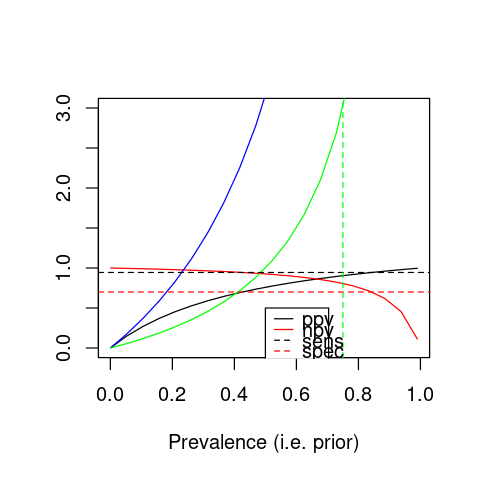

In [17]:
# https://artax.karlin.mff.cuni.cz/r-help/library/caret/html/sensitivity.html
prev <- seq(0.001, .99, length = 20)
npvVals <- ppvVals <- posOdds <- posOddsn <- priorOdds <- prev * NA
for(i in seq(along = prev))
  {
    ppvVals[i] <- posPredValue(pred, truth, prevalence = prev[i])
    npvVals[i] <- negPredValue(pred, truth, prevalence = prev[i])
    posOdds[i] <- ppvVals[i] / (1 - ppvVals[i])
    posOddsn[i] <- npvVals[i] / (1 - npvVals[i])
    priorOdds[i] <- prev[i] / (1 - prev[i])
  }

plot(prev, ppvVals,
     ylim = c(0, 3),
     type = "l",
     ylab = "",
     xlab = "Prevalence (i.e. prior)")
points(prev, npvVals, type = "l", col = "red")
points(prev, posOdds, type = "l", col = "blue")
#points(prev, posOddsn, type = "l", col = "blue")
points(prev, priorOdds, type = "l", col = "green")
#points(prev, 1 / priorOdds, type = "l", col = "green")
points(prev, posOdds / priorOdds, type = "l", col = "pink")
abline(h=sensitivity(pred, truth), lty = 2)
abline(h=specificity(pred, truth), lty = 2, col = "red")
abline(v=0.75, lty = 2, col="green")
legend(.5, .5,
       c("ppv", "npv", "sens", "spec"),
       col = c("black", "red", "black", "red"),
       lty = c(1, 1, 2, 2))

Although the likelyhood ratio is constant. It is clear that the prior and posterior odds vary with prevalence. Thus if prevalence is very small, the PPV and thus the odds are small. This means that positive results are less reliable at low prevalence than at high prevalence. The contrary happens to the negative rates.

Please have a look to http://www.nature.com/news/no-publication-without-confirmation-1.21509

## power of an experiment

http://www.sciencedirect.com/science/book/9780121790608


In [20]:
library(pwr) # follows Cohen's book

### directionality

If a research seek to reject the true null hypothesis by comparing A and B values (that could be the meand of 2 populations) if rejection is expected when A and B differ, then the test has no direction (two-tailed). To the contrary, if the true null hypothesis could be rejected when A is larger than B, then the test has a direction (one-tailed).

### significance level, $\alpha$

The significance level is the rate at which the true null hypthesis may be rejected. A researcher claims that the results from his sample are significant *if* the probability to find such results if the true null hypothesis is below $\alpha$.

$\alpha$ is also known as type-I error.

### power of a statistical test, $\beta$

"The power of a statistical test of a null hypotheis is the probability that it will lead to the rejection of the null hypothesis, i.e., the probability that it will result in the conclusion that the phenomenon exists" [Cohen]

It illustrates the fact that even if an effect exists in the population (the total of the individuals) it is not obvious that it will be represented in a sample (of the population).

For example, if the power of a test is low and no effect is found, the result should be considered with care. It is analogous to the conclusion that no substance is present because no signal is observed. A chemist will ask about the limit of detection of the equipment before concluding that the substance is not present.

Thus, the power depends on three parameters, the significance, the reliability of the sample result (sample size) and the effect size, which is the degree to which the phenomenon exists (think of the prevalence in our previous examples)

 - The reliability of the sample result is often obtained as the standard deviation of the sample (the subset of the population). 
 - The significance level is $\alpha$ and is chosen by the user as an adjustable parameter.
 - The effect size is often unknown and difficult to estimate. As its name indicate it has to do with the size of the effect that should be observed. Strong effects are easily detected, while slight ones are mucho more difficult to observe with certainty.

### flip a coin -  example

https://www.stat.berkeley.edu/~s133/Random1.html

Let's assume that we want to determine if a coin is fair or not. Therefore we can make an experiment that consists in flipping the coin a hundred time and counting the number of heads and the number of tails.

Clearly we expect both numbers to be similar. If too many tail are found we might believe that the coin is unfair. One important question is to determine this value, i.e., the acceptable difference in head or tail due to random flipping and a skewed distribution due to a manipulated coin.

Let's flip a coin hundred times and see the distribution we obtain:

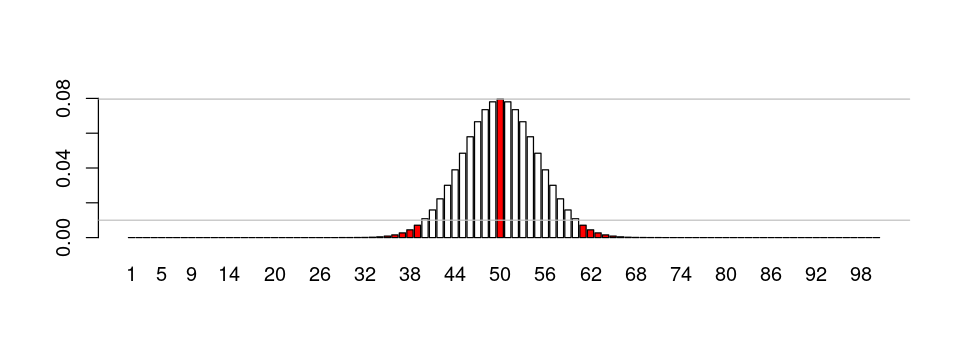

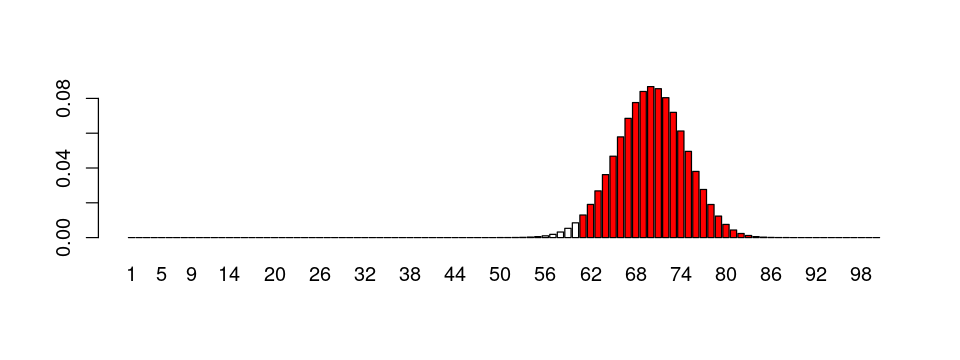

In [31]:
options(repr.plot.width=8, repr.plot.height=3) # change these setting to plot larger figures
d1 <- dbinom(1:100,100,.5)
COLOR <- c("white", "red")[(d1 < 0.01) + 1]
COLOR[50] = 2
barplot(d1,names.arg=1:100,ylim=c(0,0.08), col = COLOR)
abline(h = mean(d1), col = 'gray')
abline(h = max(d1), col = 'gray')

d2 <- dbinom(1:100,100,.7)
COLOR <- c(rep(2,40), rep(0,20) ,rep(2,40))
COLOR[50] = 2
COLOR[55] = 3
barplot(d2,names.arg=1:100,ylim=c(0,0.08), col = COLOR)

In [53]:
qbinom(.025,100,.5)
qbinom(.975,100,.5)

[1] 40

[1] 60

So we would accept the null hypothesis if results **fall** between 40 and 60. And we would be wrong in 5% of the time (note that it is a two-tailed test, so 5% means 2.5% on each side)

In [54]:
pbinom(40,100,.5)
pbinom(60,100,.5)

[1] 0.02844397

[1] 0.9823999

We simulate data and check that they behave as expected:

In [55]:
rr = rbinom(1000,100,.5);sum(rr<40|rr>60)/1000

[1] 0.04

which is very close to what we obtain using the ```pbinom()``` function.

Now, what happens if indeed the coin is not fair, i.e., one side is favoured? In this case the data would be others, but our hypothesis still would be the same, i.e., that the coin is fair. In that case we would use the same interval in order to accept or reject the null hypothesis. 

We can simulate the data that we would obtain if the coin is not fair, apply our statistical test and see what happens

In [56]:
rr = rbinom(1000,100,.55);sum(rr<40|rr>60)/1000

[1] 0.14

In [32]:
rr = rbinom(1000,100,.7);sum(rr<40|rr>60)/1000

[1] 0.975

Only in about 13% of the case we would reject the null hypothesis and declare the coin unfair... <mark>it means that in the rest of the time (about 87%) we will conclude that the coin is indeed fair.</mark>

This is a very strong conclusion. It means that with this data (a 100 coin flips) we would wrongly conclude that the coin is unfair in 5% of the case if it is indeed fair and only in 13% of the cases our data would allow us to conclude that it is unfair when it is unfair by ES(effect size)=5% (|50%-5%|). 

I we repeat the same game but this time we toss the coin 500 times.

In [57]:
alpha <- .01
upper <- qbinom(1-alpha/2,500,.5)
lower <- qbinom(alpha/2,500,.5)
upper 
lower

[1] 279

[1] 221

In [58]:
rr = rbinom(1000,500,.55);sum(rr<lower|rr>upper)/1000

[1] 0.345

It means that we are now able to detect an unfair coin (ES=5%) with a much higher rate (about 60%).

We can now design a function that will allows us to estimate the power as a function of the number of tosses:

In [59]:
coin.power <- function(ntoss=100,nsim=1000,prob=.5){
     lower <- qbinom(.025,ntoss,.5)
     upper <- qbinom(.975,ntoss,.5)
     rr <- rbinom(nsim,ntoss,prob)
     sum(rr < lower | rr > upper) / nsim
 }

1000 
0.878

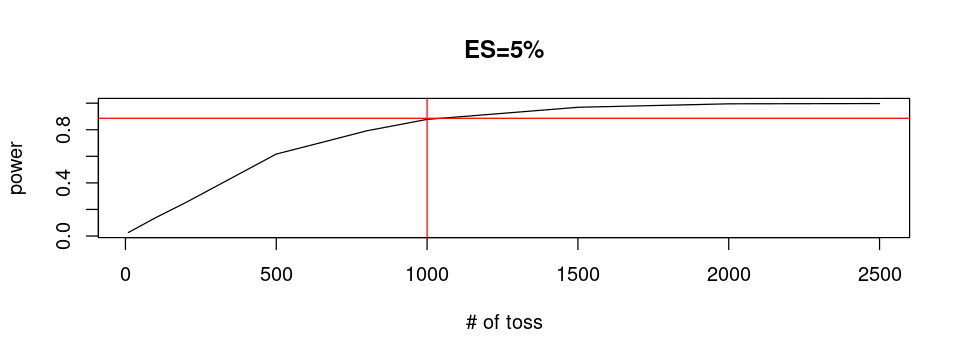

In [60]:
ntosses <- c(10,100,200,500,600,800,1000,1500,2000,2500)
res <- sapply(ntosses,coin.power,prob=.55)
names(res) <- ntosses
plot( ntosses, res , type="l", main="ES=5%",xlab="# of toss", ylab="power")
abline(v=1000, col="red")
abline(h=.886, col="red")
res[ntosses == 1000]

A researcher that would start an experiment using 1000 tosses will have a probability of finding the correct conlusion of about 90%.

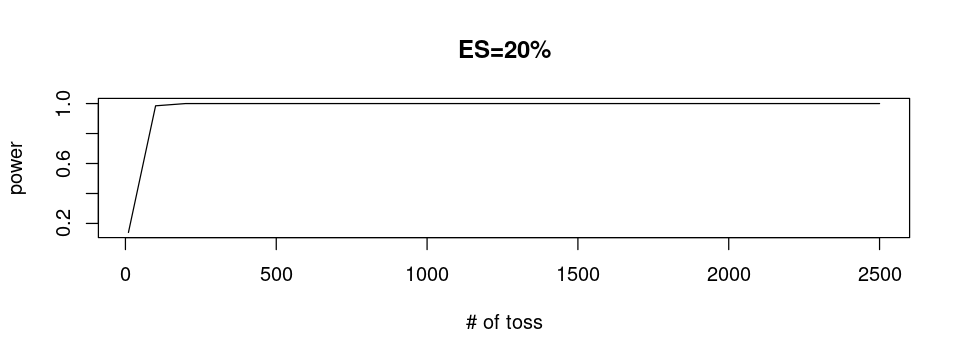

In [61]:
res = sapply(ntosses,coin.power,prob=.70)
names(res) = ntosses
plot( ntosses, res , type="l", main="ES=20%",xlab="# of toss", ylab="power")

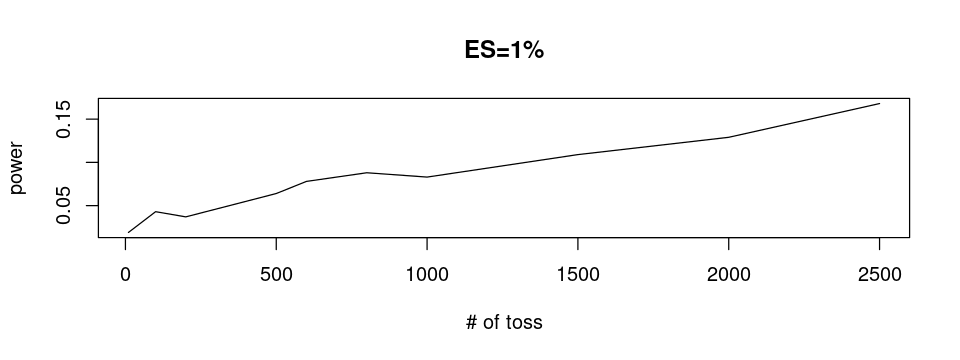

In [62]:
res = sapply(ntosses,coin.power,prob=.51)
names(res) = ntosses
plot( ntosses, res , type="l", main="ES=1%",xlab="# of toss", ylab="power")

Clearly an effect of 1% is too small to be detected event by tossing the coin a thousand times. If a researcher would run this experiment he would conclude that the coin is fair with a probability of 85%, which we know is not true. 

**Thus the researcher has a 85% probability of finding drawing the wrong conclusions. It is important to note that even if several independant research groups would repeat this experiment the probability to find the correct conclusion is very small, less than 40%.**

In [143]:
0.85^3

[1] 0.614125

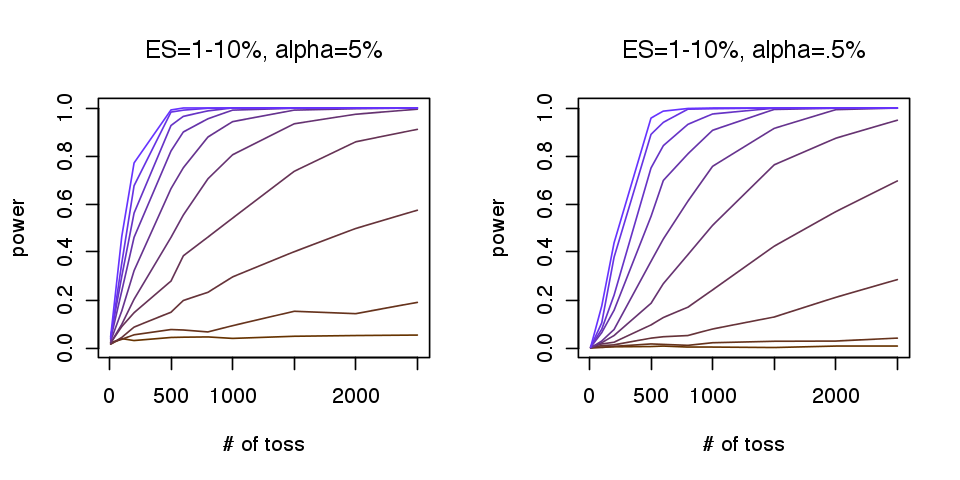

In [258]:
library(plotrix)

coin.power <- function(ntoss=100,nsim=1000,prob=.5, alpha){
     lower <- qbinom(alpha/2,ntoss,.5)
     upper <- qbinom(1-alpha/2,ntoss,.5)
     rr <- rbinom(nsim,ntoss,prob)
     sum(rr < lower | rr > upper) / nsim
 }

ntosses <- c(10,100,200,500,600,800,1000,1500,2000,2500)

options(repr.plot.width=8, repr.plot.height=4) # change these setting to plot larger figures

par(mfrow=c(1,2))

res = sapply(ntosses,coin.power,prob=.51,alpha=.05)
names(res) = ntosses
plot( ntosses, res , type="n", main="ES=1-10%, alpha=5%",xlab="# of toss", ylab="power", ylim=c(0,1))

for (i in seq(0.5,.6,length.out=10)) {
    j = scale(i, center=0.5, scale=.1)
    lines( ntosses, sapply(ntosses,coin.power,prob=i,alpha=.05), col=color.scale(1,.4,.2,j) )
}


plot( ntosses, res , type="n", main="ES=1-10%, alpha=.5%",xlab="# of toss", ylab="power", ylim=c(0,1))

for (i in seq(0.5,.6,length.out=10)) {
    j = scale(i, center=0.5, scale=.1)
    lines( ntosses, sapply(ntosses,coin.power,prob=i,alpha=.005), col=color.scale(1,.4,.2,j) )
}


<mark>On the above figure, the effect of $\alpha$ is clearly visible. If a researcher chooses to decrease the type-I error rate ($\alpha$) in order to decrease the false negative (negative being rejecting the null hyptothesis, when the coin is indeed fair), he will also decrease the power of his experiment.</mark>

This is very similar to establishing a perfect threshold value for peak detection in a spectrum. A low threshold (large $\alpha$ value) will allow to pick the signal, but will detect many spurious signals (false negatives). A high threshold (low $\alpha$ value) will avoid detecting the noise, but if set to high will prevent us to detect the signal either.

<mark>Do not say: "the difference between the two means is not statistically significant"</mark>

<mark>Say: "the data doesn't allow us to conlude that the population means differ"</mark>

p. 16 of Cohen, J. (1977). Statistical Power Analysis for the Behavioral Sciences (Rev. ed.). New York: Academic Press, Inc.